# Structural virality replication
Date: 1/27/2021

Author: Matthew Sun

In [6]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import datetime
from collections import defaultdict

import trecs
from trecs.models import BassModel
from trecs.random import SocialGraphGenerator

# custom utilities
from graph_utils import calc_avg_degree, implied_beta, scale_free_graph

In [7]:
G = scale_free_graph(1000, alpha=2.3)
k = calc_avg_degree(G)
print(f"Average degree (k): {k}")
r = 0.5 # if r = 0.5, what is the beta implied?
print(f"Implied infectiousness when r={r}: {implied_beta(k,r)}")

Average degree (k): 28.302
Implied infectiousness when r=0.5: 0.017666596000282666


Text(0.5, 1.0, 'Frequency of degree for nodes in scale-free network')

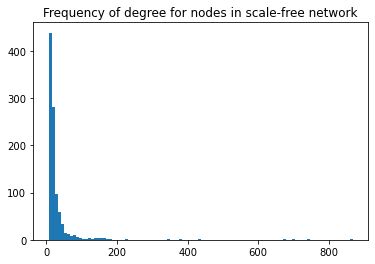

In [8]:
# plot degrees of nodes
degrees = [deg for n, deg in G.degree()]
plt.hist(degrees, bins=100)
plt.title("Frequency of degree for nodes in scale-free network")

In [9]:
def setup_experiment(num_nodes, r=0.5, alpha=2.3):
    G = scale_free_graph(num_nodes, alpha=alpha)
    user_rep = nx.convert_matrix.to_numpy_array(G) # convert to numpy adjacency matrix
    # calculate required item infectiousness
    k = calc_avg_degree(G)
    beta = implied_beta(k, r)
    item_rep = np.array([[beta]]) # must be two dimensional
    
    # seed infection with 1 user
    infection_state = np.zeros(user_rep.shape[0]).reshape(-1, 1) # must be two dimensional array
    seed_user = np.random.choice(num_nodes, 1)
    infection_state[seed_user, 0] = 1
    
    # create model
    bass = BassModel(
        user_representation=user_rep,
        item_representation=item_rep,
        infection_state=infection_state
    )
    return bass

In [27]:
# calculate metrics of interest
def popularity(simulation):
    return (simulation.infection_state != 0).sum()

def graph_popularity(sizes):
    plt.hist(sizes, bins=100)
    plt.title("Frequency of cascade sizes")
    plt.xlabel("Size")
    plt.ylabel("Frequency")
    
def prob_large_cascade(sizes):
    large_cascades = np.where(sizes > 100)[0]
    return len(large_cascades) / len(sizes)

def mean_virality(viralitys):
    # Assume virality of -1 are invalid trials
    # (i.e., the seed user was not able to infect)
    # any other user
    return viralitys[viralitys > -1].mean()

def size_virality_corr(sizes, viralitys):
    """ Calculate correlation between size of cascade
        and structural virality of cascade. Only compute
        correlation on trials where >1 node was infected
        (and therefore structural virality is computable.)
    """
    valid_sims = viralitys > -1 
    stacked_obvs = np.vstack([sizes[valid_sims], viralitys[valid_sims]])
    return np.corrcoef(stacked_obvs)[0, 1]

# Run simulation with 10k users


In [16]:
# test bass model
num_users = 10000
trials_per_setting = 250

# varying alpha and R
alphas = [2.1, 2.3, 2.5, 2.7, 2.9]
rs = [0.1, 0.3, 0.5, 0.7, 0.9]

# save result in a dictionary
# that has (alpha-r) as the key
# e.g.: 
#     {
#         (2.1, 0.1): {
#             "size" : np.array, # len: num_trials
#             "viralitys" : np.array, # len: num_trials
#         }
#     }
results = defaultdict(dict)

for alpha in alphas:
    for r in rs:
        print(f"Testing pair of parameters alpha={alpha}, r={r} at time {datetime.datetime.now()}...")
        
        size_arr = np.zeros(trials_per_setting)
        vir_arr = np.zeros(trials_per_setting)
        
        for i in range(trials_per_setting):
            if i % 50 == 0:
                print(f"\tOn trial {i} at time {datetime.datetime.now()}...")
            simulation = setup_experiment(num_users, r=r, alpha=alpha)
            simulation.run()
            size = popularity(simulation)
            size_arr[i] = size
            try:
                sv = simulation.get_structural_virality()
                vir_arr[i] = sv
            except:
                vir_arr[i] = -1 # couldn't calculate virality
        
        results[(alpha, r)]["size"] = size_arr
        results[(alpha, r)]["virality"] = vir_arr
        print("")

Testing pair of parameters alpha=2.1, r=0.1 at time 2021-01-31 14:38:13.667489...
	On trial 0 at time 2021-01-31 14:38:13.667617...
	On trial 50 at time 2021-01-31 14:44:22.167465...
	On trial 100 at time 2021-01-31 14:50:37.882055...
	On trial 150 at time 2021-01-31 14:56:49.432854...
	On trial 200 at time 2021-01-31 15:03:00.511304...

Testing pair of parameters alpha=2.1, r=0.3 at time 2021-01-31 15:09:30.735460...
	On trial 0 at time 2021-01-31 15:09:30.736178...
	On trial 50 at time 2021-01-31 15:15:29.206491...
	On trial 100 at time 2021-01-31 15:21:24.115236...
	On trial 150 at time 2021-01-31 15:27:13.656831...
	On trial 200 at time 2021-01-31 15:33:17.006003...

Testing pair of parameters alpha=2.1, r=0.5 at time 2021-01-31 15:39:53.450817...
	On trial 0 at time 2021-01-31 15:39:53.451008...
	On trial 50 at time 2021-01-31 15:46:44.085773...
	On trial 100 at time 2021-01-31 15:53:26.453535...
	On trial 150 at time 2021-01-31 15:59:49.907101...
	On trial 200 at time 2021-01-31 

In [17]:
# save results
f = open("10k_bass_results.pkl", "wb")
pkl.dump(results, f, -1)
f.close()

In [39]:
# graphing
colors=['red', 'orange', 'green', 'blue', 'purple']

Text(0, 0.5, 'Probability of popularity')

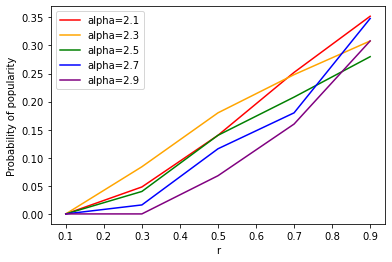

In [37]:
popularity_chance = {} # map from alpha to list, where each element corresponds to one R value
for i, alpha in enumerate(alphas):
    popularity_chance[alpha] = [prob_large_cascade(results[(alpha, r)]["size"]) for r in rs]
    plt.plot(rs, popularity_chance[alpha], label=f"alpha={alpha}", color=colors[i])
leg = plt.legend()
rainbow_legend(leg)
plt.xlabel("r")
plt.ylabel("Probability of popularity")

Text(0, 0.5, 'Mean structural virality')

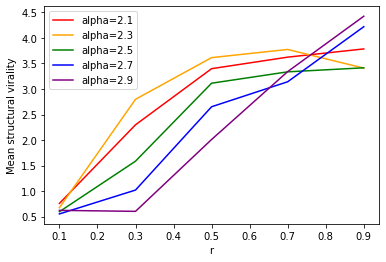

In [38]:
avg_virality = {} # map from alpha to list, where each element corresponds to one R value
for i, alpha in enumerate(alphas):
    avg_virality[alpha] = [mean_virality(results[(alpha, r)]["virality"]) for r in rs]
    plt.plot(rs, avg_virality[alpha], label=f"alpha={alpha}", color=colors[i])
plt.legend()
plt.xlabel("r")
plt.ylabel("Mean structural virality")

Text(0, 0.5, 'Correlation between size and structural virality')

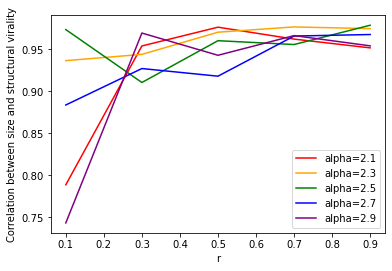

In [40]:
size_vir_corr = {} # map from alpha to list, where each element corresponds to one R value
for i, alpha in enumerate(alphas):
    size_vir_corr[alpha] = [size_virality_corr(results[(alpha, r)]["size"], results[(alpha, r)]["virality"]) for r in rs]
    plt.plot(rs, size_vir_corr[alpha], label=f"alpha={alpha}",color=colors[i])
plt.legend()
plt.xlabel("r")
plt.ylabel("Correlation between size and structural virality")

In [ ]:
graph_popularity(sizes)

In [ ]:
print(f"Probability of a large cascade: {prob_large_cascade(sizes)}")
print(f"Mean structural virality: {mean_virality(viralitys)}")
print(f"Correlation between popularity and structural virality: {size_virality_corr(sizes, viralitys)}")

# Test with sparse matrices

In [8]:
from scipy.sparse import csr_matrix, save_npz
import pickle as pkl
import os

In [ ]:
num_nodes = 1000000

print(f"Started creating graph at time {datetime.datetime.now()}...")
G = scale_free_graph(num_nodes, alpha=2.3)
print(f"Finished creating graph at time {datetime.datetime.now()}...")
user_rep = nx.convert_matrix.to_scipy_sparse_matrix(G) # convert to scipy adjacency matrix
# calculate required item infectiousness
k = calc_avg_degree(G)
beta = implied_beta(k, r)
item_rep = np.array([[beta]]) # must be two dimensional

# seed infection with 1 user
infection_state = np.zeros(user_rep.shape[0]).reshape(-1, 1) # must be two dimensional array
seed_user = np.random.choice(num_nodes, 1)
infection_state[seed_user, 0] = 1

# create model
bass = BassModel(
    user_representation=user_rep,
    item_representation=item_rep,
    infection_state=infection_state
)
print(f"Finished creating model at time {datetime.datetime.now()}...")

In [12]:
# try to create as many graphs as I can overnight
num_nodes = 1000000
for i in range(75):
    param_dict = {}
    os.mkdir(f"graphs_1m/{i}")
    G = scale_free_graph(num_nodes, alpha=2.3)
    print(f"Finished creating graph {i} at time {datetime.datetime.now()}...")
    user_rep = nx.convert_matrix.to_scipy_sparse_matrix(G) # convert to scipy adjacency matrix
    save_npz(f'graphs_1m/{i}/sparse_matrix.npz', user_rep)
    param_dict["k"] = calc_avg_degree(G)
    param_dict["beta"] = implied_beta(k, r)
    param_dict["num_nodes"] = num_nodes
    f = open(f'graphs_1m/{i}/param.pkl', 'wb')
    pkl.dump(param_dict, f, -1)
    f.close()
    break
    

Finished creating graph 0 at time 2021-01-31 12:22:52.825646...


In [ ]:
bass.run()
size = popularity(bass)
try:
    sv = bass.get_structural_virality()
except:
    pass

In [ ]:
print(size)
print(sv)